In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;


In [63]:
 test= pd.read_csv('./test (1).csv')
train = pd.read_csv('./train (1).csv')
combine = [train_df, test_df]
PassengerId = test['PassengerId']


In [17]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [18]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [77]:
 test_df= pd.read_csv('./test (1).csv')
train_df = pd.read_csv('./train (1).csv')
combine_df = pd.concat([train_df,test_df])


In [19]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [65]:
combine_df['Title'] = combine_df['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
combine_df['Title'] = combine_df['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
combine_df['Title'] = combine_df['Title'].replace(['Mlle','Ms'], 'Miss')
combine_df['Title'] = combine_df['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
df = pd.get_dummies(combine_df['Title'],prefix='Title')
combine_df = pd.concat([combine_df,df],axis=1)

In [66]:
combine_df['Fname'] = combine_df['Name'].apply(lambda x:x.split(',')[0])
combine_df['Familysize'] = combine_df['SibSp']+combine_df['Parch']
dead_female_Fname = list(set(combine_df[(combine_df.Sex=='female') & (combine_df.Age>=12)
                              & (combine_df.Survived==0) & (combine_df.Familysize>1)]['Fname'].values))
survive_male_Fname = list(set(combine_df[(combine_df.Sex=='male') & (combine_df.Age>=12)
                              & (combine_df.Survived==1) & (combine_df.Familysize>1)]['Fname'].values))
combine_df['Dead_female_family'] = np.where(combine_df['Fname'].isin(dead_female_Fname),1,0)
combine_df['Survive_male_family'] = np.where(combine_df['Fname'].isin(survive_male_Fname),1,0)
combine_df = combine_df.drop(['Name','Fname'],axis=1)

In [67]:

group = combine_df.groupby(['Title', 'Pclass'])['Age']
combine_df['Age'] = group.transform(lambda x: x.fillna(x.median()))
combine_df = combine_df.drop('Title',axis=1)

combine_df['IsChild'] = np.where(combine_df['Age']<=12,1,0)
combine_df['Age'] = pd.cut(combine_df['Age'],5)
combine_df = combine_df.drop('Age',axis=1)

In [68]:
combine_df['Familysize'] = np.where(combine_df['Familysize']==0, 'solo',
                                    np.where(combine_df['Familysize']<=3, 'normal', 'big'))
df = pd.get_dummies(combine_df['Familysize'],prefix='Familysize')
combine_df = pd.concat([combine_df,df],axis=1).drop(['SibSp','Parch','Familysize'])


In [69]:
combine_df['Ticket_Lett'] = combine_df['Ticket'].apply(lambda x: str(x)[0])
combine_df['Ticket_Lett'] = combine_df['Ticket_Lett'].apply(lambda x: str(x))

combine_df['High_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
combine_df['Low_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['A','W','3','7']),1,0)
combine_df = combine_df.drop(['Ticket','Ticket_Lett'],axis=1)


In [70]:
combine_df.Embarked = combine_df.Embarked.fillna('S')
df = pd.get_dummies(combine_df['Embarked'],prefix='Embarked')
combine_df = pd.concat([combine_df,df],axis=1).drop('Embarked',axis=1)

In [71]:
combine_df['Cabin_isNull'] = np.where(combine_df['Cabin'].isnull(),0,1)
combine_df = combine_df.drop('Cabin',axis=1)

In [72]:
df = pd.get_dummies(combine_df['Pclass'],prefix='Pclass')
combine_df = pd.concat([combine_df,df],axis=1).drop('Pclass',axis=1)

In [73]:
df = pd.get_dummies(combine_df['Sex'],prefix='Sex')
combine_df = pd.concat([combine_df,df],axis=1).drop('Sex',axis=1)

In [74]:
combine_df['Fare'] = pd.qcut(combine_df.Fare,3)
df = pd.get_dummies(combine_df.Fare,prefix='Fare').drop('Fare_(-0.001, 8.662]',axis=1)
combine_df = pd.concat([combine_df,df],axis=1).drop('Fare',axis=1)

ValueError: labels ['Fare_(-0.001, 8.662]'] not contained in axis

In [78]:
#Title
combine_df['Title'] = combine_df['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
combine_df['Title'] = combine_df['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
combine_df['Title'] = combine_df['Title'].replace(['Mlle','Ms'], 'Miss')
combine_df['Title'] = combine_df['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
df = pd.get_dummies(combine_df['Title'],prefix='Title')
combine_df = pd.concat([combine_df,df],axis=1)

#Name_length
combine_df['Name_Len'] = combine_df['Name'].apply(lambda x: len(x))
combine_df['Name_Len'] = pd.qcut(combine_df['Name_Len'],5)


#Dead_female_family & Survive_male_family
combine_df['Surname'] = combine_df['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(combine_df[(combine_df.Sex=='female') & (combine_df.Age>=12)
                              & (combine_df.Survived==0) & ((combine_df.Parch>0) | (combine_df.SibSp > 0))]['Surname'].values))
survive_male_surname = list(set(combine_df[(combine_df.Sex=='male') & (combine_df.Age>=12)
                              & (combine_df.Survived==1) & ((combine_df.Parch>0) | (combine_df.SibSp > 0))]['Surname'].values))
combine_df['Dead_female_family'] = np.where(combine_df['Surname'].isin(dead_female_surname),0,1)
combine_df['Survive_male_family'] = np.where(combine_df['Surname'].isin(survive_male_surname),0,1)
combine_df = combine_df.drop(['Name','Surname'],axis=1)


#Age & isChild
group = combine_df.groupby(['Title', 'Pclass'])['Age']
combine_df['Age'] = group.transform(lambda x: x.fillna(x.median()))
combine_df = combine_df.drop('Title',axis=1)
combine_df['IsChild'] = np.where(combine_df['Age']<=12,1,0)
combine_df['Age'] = pd.cut(combine_df['Age'],5)
combine_df = combine_df.drop('Age',axis=1)

#ticket
combine_df['Ticket_Lett'] = combine_df['Ticket'].apply(lambda x: str(x)[0])
combine_df['Ticket_Lett'] = combine_df['Ticket_Lett'].apply(lambda x: str(x))

combine_df['High_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
combine_df['Low_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['A','W','3','7']),1,0)
combine_df = combine_df.drop(['Ticket','Ticket_Lett'],axis=1)

#Embarked
#combine_df = combine_df.drop('Embarked',axis=1)
combine_df.Embarked = combine_df.Embarked.fillna('S')
df = pd.get_dummies(combine_df['Embarked'],prefix='Embarked')
combine_df = pd.concat([combine_df,df],axis=1).drop('Embarked',axis=1)

#FamilySize
combine_df['FamilySize'] = np.where(combine_df['SibSp']+combine_df['Parch']==0, 'Alone',
                                    np.where(combine_df['SibSp']+combine_df['Parch']<=3, 'Small', 'Big'))
df = pd.get_dummies(combine_df['FamilySize'],prefix='FamilySize')
combine_df = pd.concat([combine_df,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)


#Cabin
combine_df['Cabin_isNull'] = np.where(combine_df['Cabin'].isnull(),0,1)
combine_df = combine_df.drop('Cabin',axis=1)

#PClass
df = pd.get_dummies(combine_df['Pclass'],prefix='Pclass')
combine_df = pd.concat([combine_df,df],axis=1).drop('Pclass',axis=1)


#Sex
df = pd.get_dummies(combine_df['Sex'],prefix='Sex')
combine_df = pd.concat([combine_df,df],axis=1).drop('Sex',axis=1)

#Fare
combine_df['Fare'].fillna(combine_df['Fare'].dropna().median(),inplace=True)
combine_df['Low_Fare'] = np.where(combine_df['Fare']<=8.662,1,0)
combine_df['High_Fare'] = np.where(combine_df['Fare']>=26,1,0)
combine_df = combine_df.drop('Fare',axis=1)

In [79]:
features = combine_df.drop(["PassengerId","Survived"], axis=1).columns
le = LabelEncoder()
for feature in features:
    le = le.fit(combine_df[feature])
    combine_df[feature] = le.transform(combine_df[feature])

In [86]:
X_all

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Name_Len,Dead_female_family,Survive_male_family,IsChild,High_Survival_Ticket,Low_Survival_Ticket,...,FamilySize_Big,FamilySize_Small,Cabin_isNull,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Low_Fare,High_Fare
0,0,0,1,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,1,1,0
1,0,0,0,1,3,1,1,0,1,0,...,0,1,1,1,0,0,1,0,0,1
2,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,0,0,0,1,3,1,1,0,1,0,...,0,1,1,1,0,0,1,0,0,1
4,0,0,1,0,1,1,1,0,0,1,...,0,0,0,0,0,1,0,1,1,0
5,0,0,1,0,4,1,1,0,0,1,...,0,0,0,0,0,1,0,1,1,0
6,0,0,1,0,0,1,1,0,1,0,...,0,0,1,1,0,0,0,1,0,1
7,1,0,0,0,2,0,1,1,0,1,...,1,0,0,0,0,1,0,1,0,0
8,0,0,0,1,3,1,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
9,0,0,0,1,3,1,1,0,1,0,...,0,1,0,0,1,0,1,0,0,1


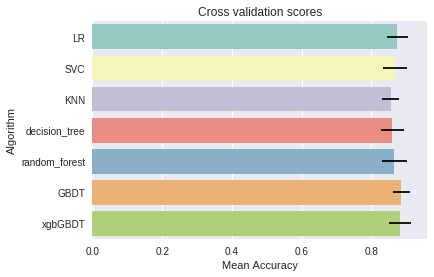

In [80]:
X_all = combine_df.iloc[:891,:].drop(["PassengerId","Survived"], axis=1)
Y_all = combine_df.iloc[:891,:]["Survived"]
X_test = combine_df.iloc[891:,:].drop(["PassengerId","Survived"], axis=1)

logreg = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.03)
clfs = [logreg, svc, knn, decision_tree, random_forest, gbdt, xgb]

kfold = 10
cv_results = []
for classifier in clfs :
    cv_results.append(cross_val_score(classifier, X_all.values, y = Y_all.values, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

ag = ["LR","SVC",'KNN','decision_tree',"random_forest","GBDT","xgbGBDT"]
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":ag})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [81]:
from sklearn.metrics import precision_score

class Bagging(object):
    
    def __init__(self,estimators):
        self.estimator_names = []
        self.estimators = []
        for i in estimators:
            self.estimator_names.append(i[0])
            self.estimators.append(i[1])
        self.clf = LogisticRegression()
    
    def fit(self, train_x, train_y):
        for i in self.estimators:
            i.fit(train_x,train_y)
        x = np.array([i.predict(train_x) for i in self.estimators]).T
        y = train_y
        self.clf.fit(x, y)
    
    def predict(self,x):
        x = np.array([i.predict(x) for i in self.estimators]).T
        #print(x)
        return self.clf.predict(x)
        
    
    def score(self,x,y):
        s = precision_score(y,self.predict(x))
        #print(s)
        return s

In [82]:
# from sklearn.model_selection import train_test_split

# from xgboost import XGBClassifier
# xgbGBDT0 = XGBClassifier(learning_rate =0.1, n_estimators=5000, max_depth=6, min_child_weight=4,
#                          gamma=0.2, subsample=0.8, colsample_bytree=0.7, reg_alpha=0.005, 
#                          objective= 'binary:logistic', nthread=4)
# # array_trainx = tra.values
# # array_trainy = y_tra.values.ravel()
# num_test = 0.20
# array_trainx, X_cv, array_trainy, Y_cv = train_test_split(x_train, y_train, test_size=num_test)
# eval_set=[(X_cv,Y_cv)]
# xgbGBDT0.fit(x_train,y_train,eval_metric="logloss",verbose=True,eval_set=eval_set)

# # acc_xgb = round(xgbGBDT0.score(X_cv, Y_cv) * 100, 2)
# # print(acc_xgb)

# # Y_test0 = xgbGBDT0.predict_proba(x_test.values)

In [83]:

lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgbGBDT = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.03)
clfs = [logreg, svc, knn, decision_tree, random_forest, gbdt, xgb]

bag = Bagging([('xgb',xgb),('lr',lr),('gbdt',gbdt),('rf',rf)])

from sklearn.metrics import precision_score

In [84]:

score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all.values, Y_all.values, test_size=num_test)
    bag.fit(X_train, Y_train)
    #Y_test = bag.predict(X_test)
    acc_xgb = round(bag.score(X_cv, Y_cv) * 100, 2)
    score+=acc_xgb
score/10

87.804999999999993

In [85]:
bag.fit(X_all.values, Y_all.values)
Y_test = bag.predict(X_test.values).astype(int)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_test
    })
submission.to_csv(r'submission.csv', index=False)

In [ ]:
xgbGBDT0.predict

In [30]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import operator
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import warnings
warnings.filterwarnings('ignore')

,Algorithm,CrossValMeans,CrossValerrors
0,LR,0.811418,0.024705
1,SVC,0.800220,0.030484
2,KNN,0.776837,0.050126
3,decision_tree,0.805914,0.045864
4,random_forest,0.820496,0.038961
5,GBDT,0.822693,0.027303
6,xgbGBDT,0.838436,0.028638


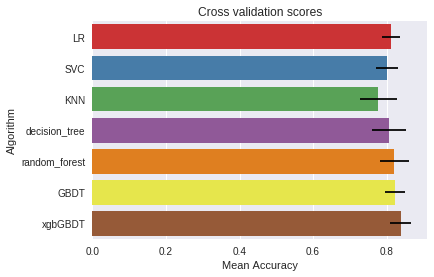

In [60]:
lr = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgbGBDT = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

clfs = [lr, svc, knn, dt, rf, gbdt, xgbGBDT]
kfold = 10
cv_results = []
for classifier in clfs :
    cv_results.append(cross_val_score(classifier, x_train, y_train , scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LR","SVC",'KNN','decision_tree',"random_forest","GBDT","xgbGBDT"]})
# cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
#                         "Algorithm":["xgbGBDT1"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set1",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
cv_res=pd.DataFrame(cv_res)
cv_res

In [61]:
class Ensemble(object):
    
    def __init__(self,estimators):
        self.estimator_names = []
        self.estimators = []
        for i in estimators:
            self.estimator_names.append(i[0])
            self.estimators.append(i[1])
        self.clf = LogisticRegression()
    
    def fit(self, train_x, train_y):
        for i in self.estimators:
            i.fit(train_x,train_y)
        x = np.array([i.predict(train_x) for i in self.estimators]).T
        y = train_y
        self.clf.fit(x, y)
    
    def predict(self,x):
        x = np.array([i.predict(x) for i in self.estimators]).T
        #print(x)
        return self.clf.predict(x)
        
    
    def score(self,x,y):
        s = precision_score(y,self.predict(x))
        return s

In [62]:
bag = Ensemble([('xgbGBDT',xgbGBDT),('lr',lr),('rf',rf),('svc',svc),('gbdt',gbdt)])
score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(x_train, y_train,test_size=num_test)
    bag.fit(X_train, Y_train)
    Y_test = bag.predict(x_test)
    acc_xgb = round(bag.score(X_cv, Y_cv) * 100, 2)
    score+=acc_xgb
print(score/10)  

80.035


In [56]:
Y_test.values

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
    

In [59]:
aaa = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': Y_test })
aaa.to_csv('test.csv', index=False)